# **Computer Lab 2 - Hugo Queniat**

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

5


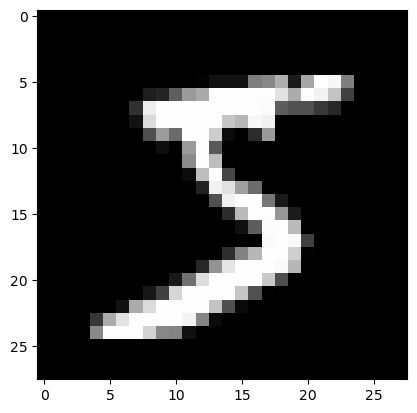

In [21]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

In [31]:
# source: https://keras.io/guides/training_with_built_in_methods/

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#def loss(true, pred):
#    val = 0.
#    for i in range(len(true)):
#        val -= np.log(pred[i, true[i]])
#    return val / len(true)
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


## **Question 4.1**

There are 26,506 optimization variables to train.

In [32]:
# untrained model
logits = model(x_train)
np.argmax(logits, 1)[0:100]

array([4, 4, 2, 2, 4, 7, 4, 2, 4, 2, 4, 8, 4, 0, 4, 5, 4, 4, 0, 7, 5, 4,
       5, 2, 4, 4, 0, 4, 4, 4, 5, 7, 5, 7, 7, 7, 4, 4, 5, 7, 4, 4, 4, 4,
       4, 0, 4, 2, 4, 4, 4, 4, 4, 7, 4, 4, 4, 0, 0, 0, 5, 2, 2, 5, 4, 7,
       5, 2, 4, 4, 4, 7, 4, 7, 4, 7, 4, 7, 7, 7, 4, 7, 7, 0, 4, 7, 4, 0,
       4, 4, 3, 4, 5, 0, 4, 4, 5, 4, 4, 7])

In [33]:
# what we would like to get
y_train[0:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

In [34]:
## Computing a stochastic gradient

# Source: https://keras.io/guides/writing_a_training_loop_from_scratch/

# Example of gradient computation using automatic differentiation

x_train_batch = x_train[:8]
y_train_batch = y_train[:8]
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        logits = model(x_train_batch)  # Logits for this minibatch

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

## Updating weights

def update_weights(model, update):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + update[i]
    model.set_weights(new_weights)


## Evaluate model
samples_for_evaluation = np.random.randint(0, 10000, 1000)
logits = model(x_train[samples_for_evaluation])
loss(y_train[samples_for_evaluation], logits).numpy()
    

2.389213

## **Question 5.1**

In [40]:
def stochastic_gradient_descent(x_train, y_train, model, batch_size, initial_step_size=1, step_size_exponent=0.5, 
                                print_loss_every=None, verbose=False):
        
    num_samples = x_train.shape[0]
    num_steps = num_samples // batch_size
    if print_loss_every is None:
        print_loss_every = num_steps // 20
    indices = np.arange(0, num_samples)
    np.random.shuffle(indices)
    indices_per_step = np.array_split(indices, num_steps)
    steps, losses = [], []
    step_size = initial_step_size
    for step, idx in enumerate(indices_per_step):
        
        if step % print_loss_every == 0:
            loss_value = loss(y_train, model(x_train)).numpy()
            steps.append(step)
            losses.append(loss_value)
            if verbose:
                print(f"step {step}/{num_steps}: loss_value={loss_value:.6g}")       
        x_batch = x_train[idx]
        y_batch = y_train[idx]
        with tf.GradientTape() as tape:
            logits = model(x_batch)
            loss_value = loss(y_batch, logits)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        updates = [tf.math.scalar_mul(-step_size/batch_size, t) for t in gradients]
        update_weights(model, updates)
    return steps, losses


## **Question 5.2**

In [ ]:
# Running SGD for one pass over the data with graphical output

steps, losses = stochastic_gradient_descent(x_train, y_train, model, 1, initial_step_size=0.1, print_loss_every=100, verbose=True)

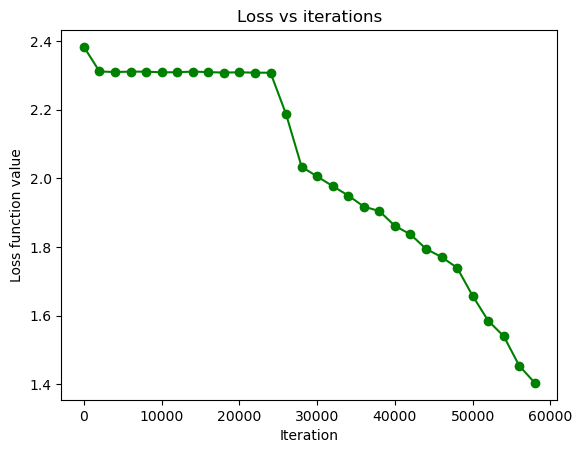

In [38]:
fig = plt.figure()
plt.plot(steps, losses, "-og")
plt.title("Loss vs iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss function value")
plt.show()

There is a convergence to 0 but it is slow (we are still a long way from 0 after 60000 steps...)

## **Question 6.1**

In [46]:
# Empirical risk minimization

def sgd(x_train, y_train, model, batch_size, n_epochs, gamma0=1, alpha=0.5, loss_every=None, verbose=False):
    epoch_steps, epoch_losses = [], []
    for epoch in range(n_epochs):
        print(f"================== EPOCH {epoch + 1}/{n_epochs} ==================")
        steps, losses = stochastic_gradient_descent(x_train, y_train, model, batch_size, gamma0, alpha, loss_every, verbose)
        epoch_steps.append(steps)
        epoch_losses.append(losses)
    return epoch_steps, epoch_losses


In [47]:
steps, losses = sgd(x_train, y_train, model, batch_size=32, n_epochs=10)

================== EPOCH 1/10 ==================
================== EPOCH 2/10 ==================
================== EPOCH 3/10 ==================
================== EPOCH 4/10 ==================
================== EPOCH 5/10 ==================
================== EPOCH 6/10 ==================
================== EPOCH 7/10 ==================
================== EPOCH 8/10 ==================
================== EPOCH 9/10 ==================
================== EPOCH 10/10 ==================


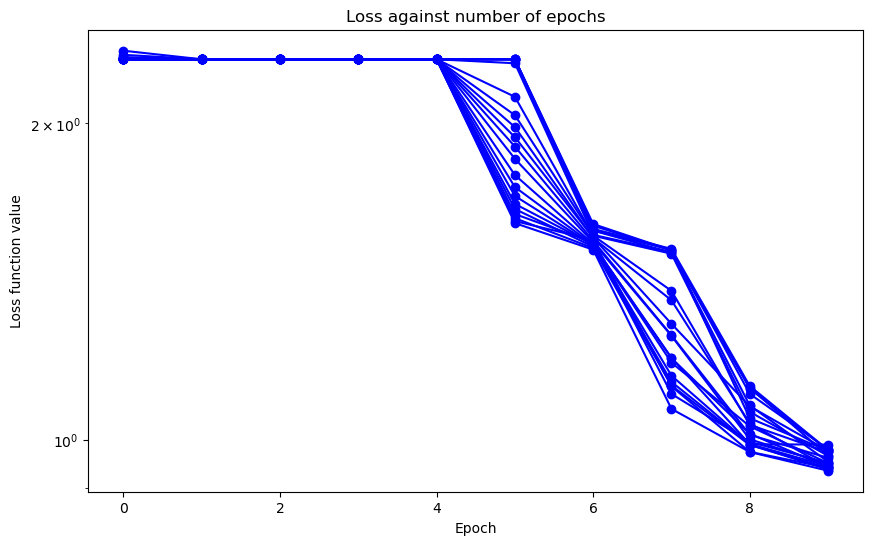

In [48]:
fig = plt.figure(figsize=(10, 6))
plt.plot(losses, "-ob")
plt.yscale("log")
plt.title("Loss against number of epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss function value")
plt.show()

## **Question 6.2**

We can on run on several epochs and have a lesser loss function value with a minimized computation time ! So there is progress in every aspect of the algorithm.